In [10]:
!pip install deepxde

In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

import deepxde as dde
from deepxde.backend import tf

Compiling model...
Building feed-forward neural network...
'build' took 0.078924 s

'compile' took 0.718390 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.18e+01]    [4.91e+01]    [3.06e-01]    
1000      [2.27e-06]    [3.93e+00]    [1.39e-02]    
2000      [5.72e-06]    [3.86e+00]    [1.40e-02]    
3000      [4.31e-04]    [3.69e+00]    [1.41e-02]    
4000      [1.63e-02]    [3.43e+00]    [1.38e-02]    
5000      [4.67e-07]    [3.15e+00]    [1.44e-02]    
6000      [4.82e-09]    [2.88e+00]    [1.44e-02]    
7000      [4.31e-04]    [2.60e+00]    [1.42e-02]    
8000      [2.77e-07]    [2.39e+00]    [1.41e-02]    
9000      [2.65e-04]    [2.17e+00]    [1.40e-02]    
10000     [3.25e-09]    [2.00e+00]    [1.36e-02]    
11000     [8.13e-08]    [1.87e+00]    [1.33e-02]    
12000     [5.70e-05]    [1.79e+00]    [1.30e-02]    
13000     [2.32e-08]    [1.75e+00]    [1.29e-02]    
14000     [6.97e-04]    [1.72e+00]    [1.26e-02]    
15000     [2.91e-02]  

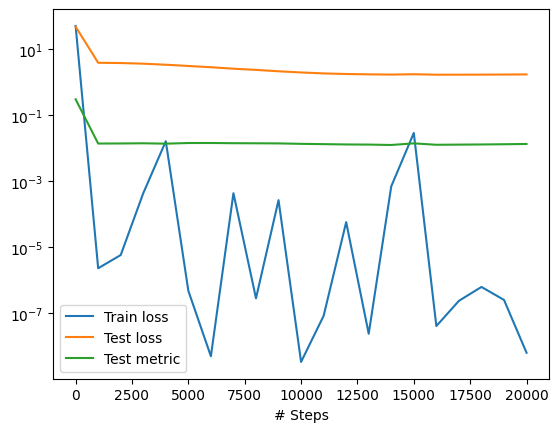

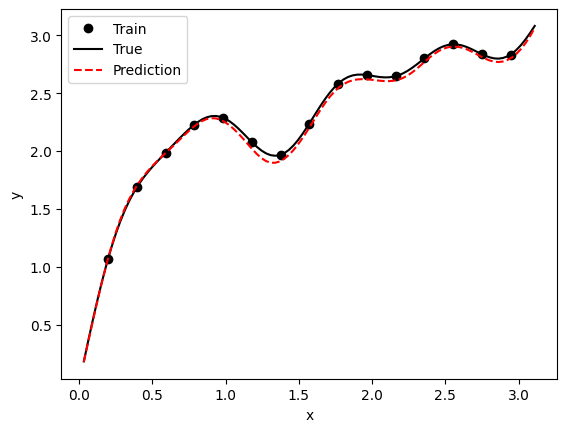

In [12]:
# PINN
def PINNpde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    f = 8 * tf.sin(8 * x)
    for i in range(1, 5):
        f += i * tf.sin(i * x)
    return -dy_xx - f


def func(x):
    sol = x + 1 / 8 * np.sin(8 * x)
    for i in range(1, 5):
        sol += 1 / i * np.sin(i * x)
    return sol


geom = dde.geometry.Interval(0, np.pi)

data = dde.data.PDE(geom, PINNpde, [], 15, 0, "uniform", solution=func, num_test=100)

layer_size = [1] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)


def output_transform(x, y):
    return x + tf.math.tanh(x) * tf.math.tanh(np.pi - x) * y


net.apply_output_transform(output_transform)

PINNmodel = dde.Model(data, net)
PINNmodel.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = PINNmodel.train(epochs=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.070160 s

'compile' took 1.700813 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [5.18e+01, 1.90e+01]    [4.91e+01, 2.18e+01]    [3.06e-01]    
1000      [6.71e-03, 1.50e-02]    [2.39e-01, 5.57e-01]    [1.09e-02]    
2000      [1.15e-03, 3.92e-03]    [1.83e-01, 4.46e-01]    [9.13e-03]    
3000      [3.11e-04, 1.43e-03]    [1.61e-01, 4.09e-01]    [7.72e-03]    
4000      [1.42e-04, 7.61e-04]    [1.52e-01, 3.89e-01]    [7.13e-03]    
5000      [1.28e-02, 1.06e-02]    [1.49e-01, 3.82e-01]    [7.91e-03]    
6000      [9.74e-05, 2.35e-04]    [1.45e-01, 3.71e-01]    [6.79e-03]    
7000      [3.40e-05, 1.81e-04]    [1.43e-01, 3.67e-01]    [6.85e-03]    
8000      [1.03e-05, 8.87e-05]    [1.44e-01, 3.67e-01]    [6.81e-03]    
9000      [1.43e-04, 1.35e-04]    [1.45e-01, 3.70e-01]    [6.72e-03]    
10000     [8.99e-05, 1.23e-04]    [1.44e-01, 3.72e-01]    [6.91e-03

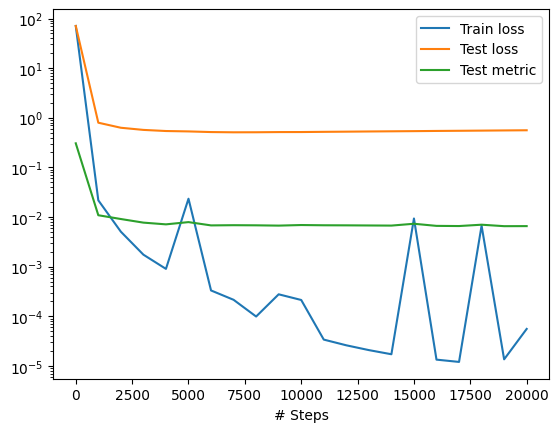

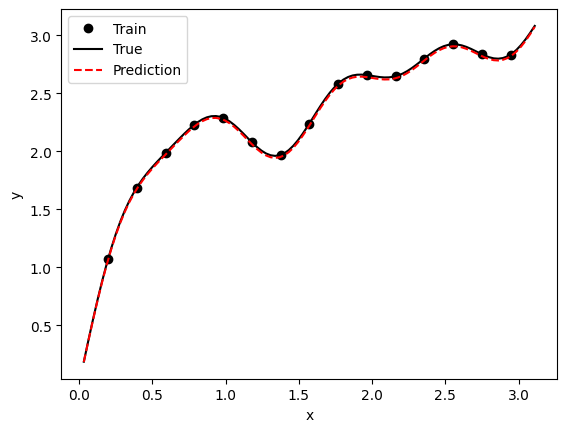

In [13]:
# gPINN
def gPINNpde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    dy_xxx = dde.grad.jacobian(dy_xx, x)

    f = 8 * tf.sin(8 * x)
    for i in range(1, 5):
        f += i * tf.sin(i * x)
    df_x = (
        tf.cos(x)
        + 4 * tf.cos(2 * x)
        + 9 * tf.cos(3 * x)
        + 16 * tf.cos(4 * x)
        + 64 * tf.cos(8 * x)
    )

    return [-dy_xx - f, -dy_xxx - df_x]


geom = dde.geometry.Interval(0, np.pi)

data = dde.data.PDE(geom, gPINNpde, [], 15, 0, "uniform", solution=func, num_test=100)

layer_size = [1] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)


def output_transform(x, y):
    return x + tf.math.tanh(x) * tf.math.tanh(np.pi - x) * y


net.apply_output_transform(output_transform)

gPINNmodel = dde.Model(data, net)
gPINNmodel.compile(
    "adam", lr=0.001, metrics=["l2 relative error"], loss_weights=[1, 0.01]
)
losshistory, train_state = gPINNmodel.train(epochs=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

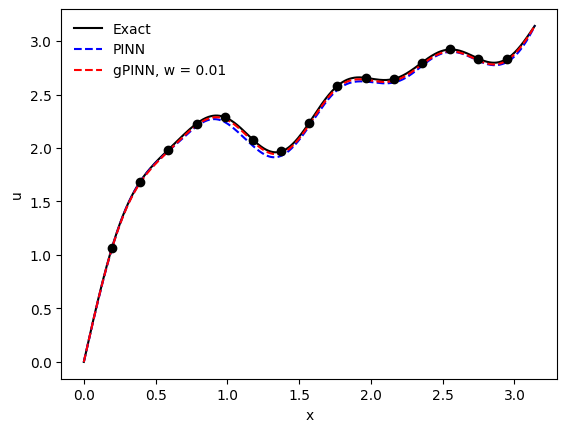

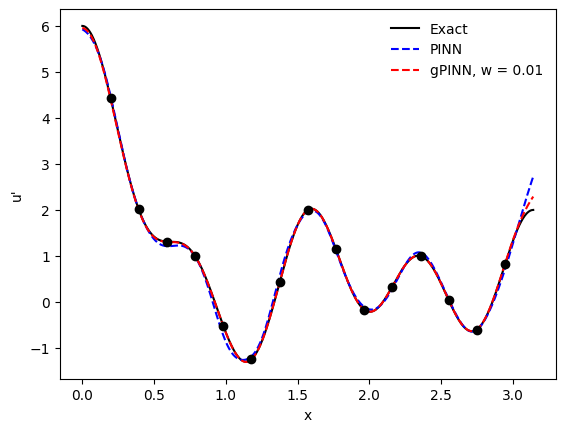

In [14]:
# plots

x = geom.uniform_points(1000)

plt.figure()
plt.plot(x, func(x), label="Exact", color="black")
plt.plot(x, PINNmodel.predict(x), label="PINN", color="blue", linestyle="dashed")
plt.plot(
    x, gPINNmodel.predict(x), label="gPINN, w = 0.01", color="red", linestyle="dashed"
)
plt.legend(frameon=False)

x = geom.uniform_points(15, boundary=False)
plt.plot(x, func(x), color="black", marker="o", linestyle="none")
plt.xlabel("x")
plt.ylabel("u")



x = geom.uniform_points(1000)
def du_x(x):
    return 1 + np.cos(x) + np.cos(2 * x) + np.cos(3 * x) + np.cos(4 * x) + np.cos(8 * x)

plt.figure()
plt.plot(x, du_x(x), label="Exact", color="black")
plt.plot(
    x,
    PINNmodel.predict(x, operator=lambda x, y: dde.grad.jacobian(y, x)),
    label="PINN",
    color="blue",
    linestyle="dashed",
)
plt.plot(
    x,
    gPINNmodel.predict(x, operator=lambda x, y: dde.grad.jacobian(y, x)),
    label="gPINN, w = 0.01",
    color="red",
    linestyle="dashed",
)

x = geom.uniform_points(15, boundary=False)
plt.plot(x, du_x(x), color="black", marker="o", linestyle="none")

plt.legend(frameon=False)
plt.xlabel("x")
plt.ylabel("u'")

plt.show()